<a href="https://colab.research.google.com/github/DenisSurovin/Titanic-dataset/blob/main/Titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Датасет представляет из себя данные о пассажирах Титаника. Необходимо решить задачу классификации, то есть по заданным параметрам пассажира определить, выжил ли он при крушении или нет.

Подключим необходимые библиотеки и загрузим данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('https://raw.githubusercontent.com/DenisSurovin/Titanic-dataset/refs/heads/main/Titanic-Dataset.csv')

Проверка на правильность чтения данных.

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Размер датасета.

In [3]:
data.shape

(891, 12)

Уберем лишние данные. PassengerId - уникальный номер пассажира, он зависит только от порядка включения пассажиров в датасет, и от него не зависит выживание пассажира. Name - имя пассажира, Ticket - номер его билета, Cabin - номер каюты. Эти признаки являются категориальными, причем уникальных значений признаков достаточно много (почти каждый пассажир обладает уникальным именем, номером каюты и номером билета), поэтому при использовании one-hot-encoding возникло бы слишком много новых признаков, а поскольку от этих признаков вряд ли зависит выживание пассажира, то не будем использовать их при построении моделей.

In [4]:
data_fixed = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin']).copy()

In [5]:
data_fixed.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Проверим на наличие пропущенных значений.

In [6]:
data_fixed.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0
Embarked,2


У большого количества пассажиров неизвестен их возраст, поэтому заменим пропущенные значения на средний возраст остальных пассажирова.

In [7]:
data_fixed.Age = data_fixed.Age.fillna(value=data_fixed.Age.mean())

Также, пропущенно два значения признака Embarked - порта отправления. Найдем моду известных значений этого признака.

In [8]:
data_fixed.Embarked.mode()

,Embarked
0,S


И заменим пропущенные значения на S - Саутгемптон.

In [9]:
data_fixed.Embarked = data_fixed.Embarked.fillna(value='S')

Используем one-hot-encoding для кодирования категориальных признаков Sex - пол и Embarked - порт отправления. Будем считать, что если признак Sex_female = 0, то Sex = male, а если Embarked_C = 0 и Embarked_S = 0, то Embarked = Q.

In [10]:
data_fixed = pd.get_dummies(data_fixed, columns=['Sex', 'Embarked'], dtype=int)
data_fixed = data_fixed.drop(columns=['Sex_male', 'Embarked_Q'])
data_fixed.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_S
0,0,3,22.0,1,0,7.2500,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0
2,1,3,26.0,0,0,7.9250,1,0,1
3,1,1,35.0,1,0,53.1000,1,0,1
4,0,3,35.0,0,0,8.0500,0,0,1


Посмотрим на количество уникальных значений целевой переменной Survived.

In [11]:
data_fixed.Survived.value_counts()

,count
Survived,
0,549
1,342


Классы немного несбалансированы, поэтому для более корректной оценки эффективности работы моделей будем использовать метрику F1.

Построим диаграммы рассеяния и гистограммы признаков. Для наглядности, уберем признаки Embarked_S и Embarked_C.

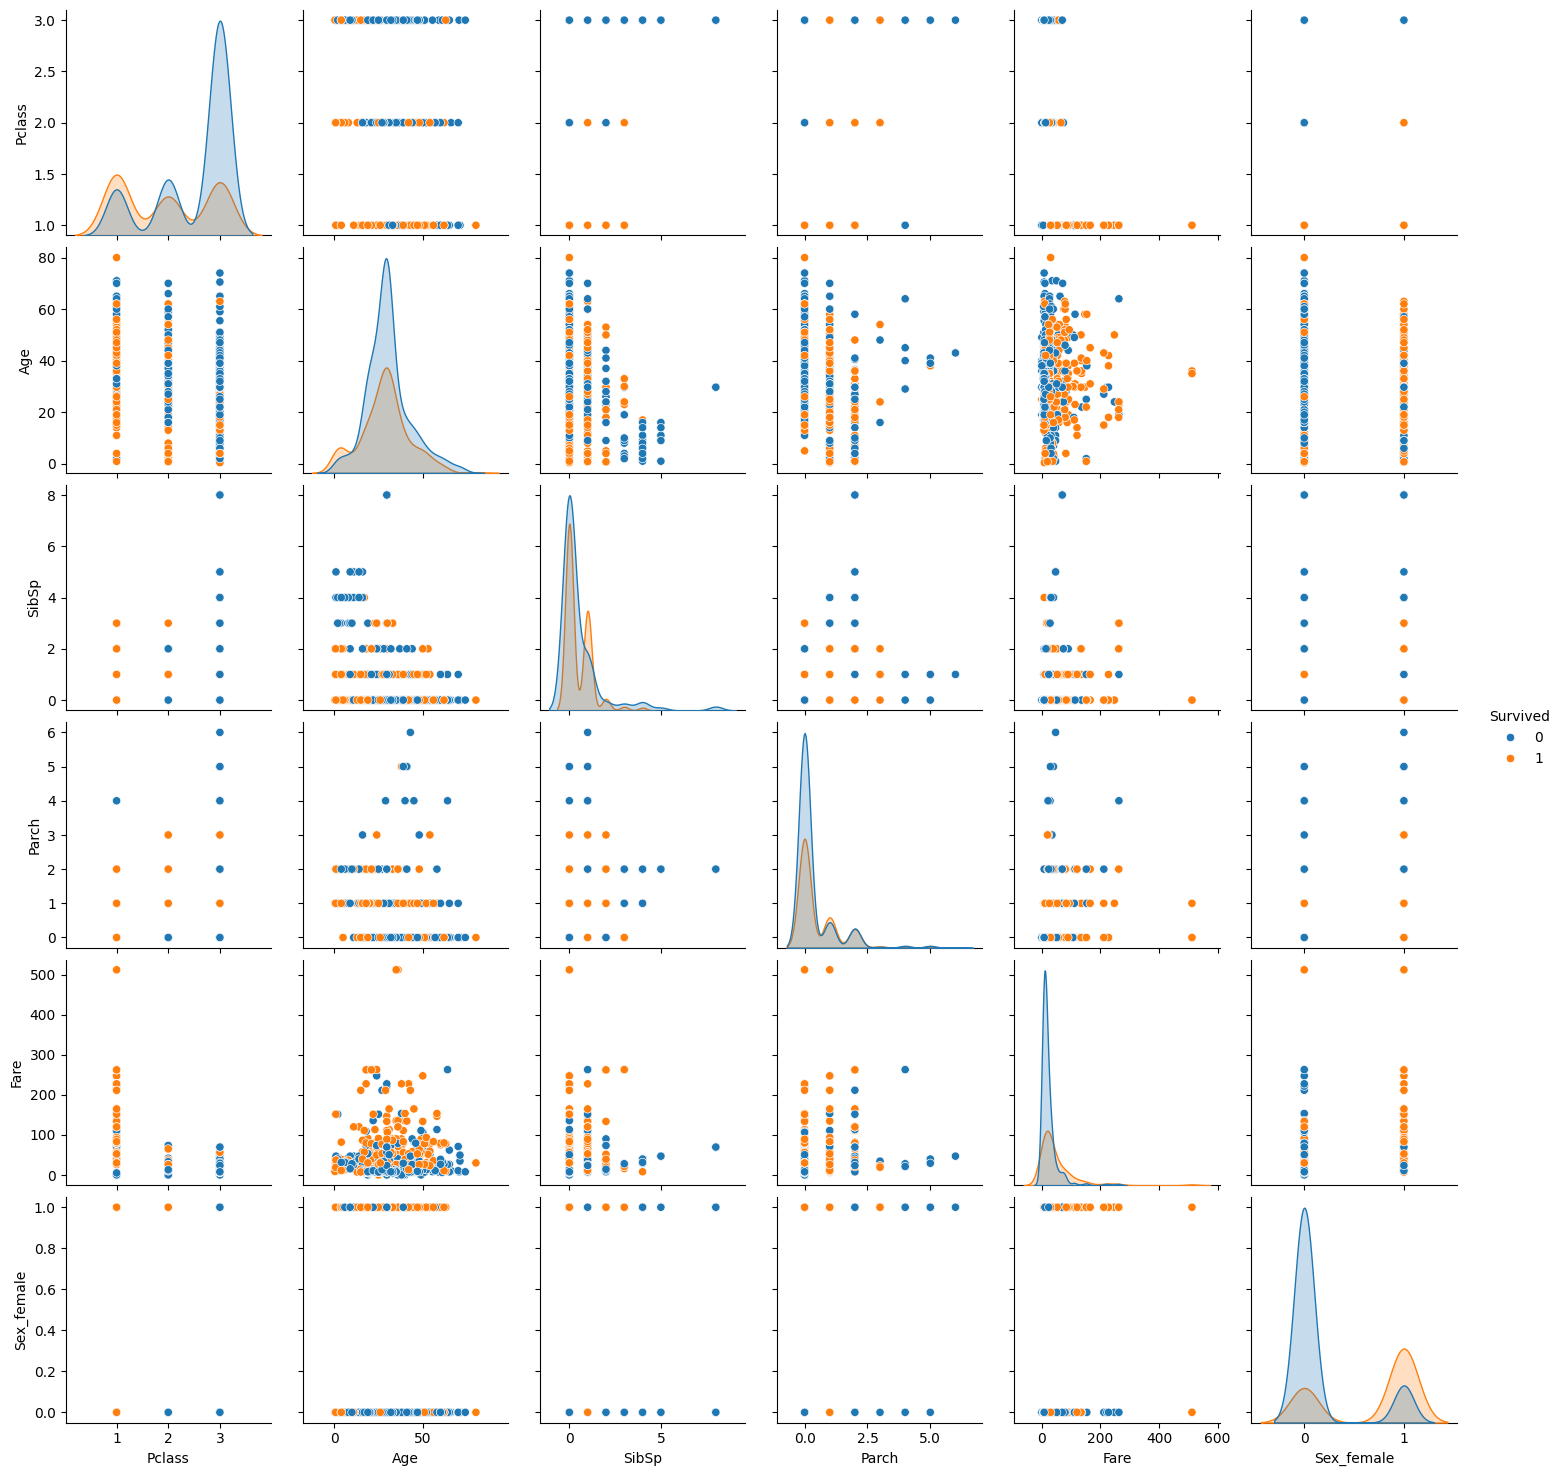

In [12]:
sns.pairplot(data_fixed.drop(columns=['Embarked_C', 'Embarked_S']), hue='Survived')

Классы выглядят трудноразделимыми, поэтому попробуем использовать ансамбли моделей.

Разделим выборку на обучающую, валидационную и тестовую.

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_fixed, random_state=42, stratify=data_fixed.Survived, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(data_train.drop(columns=['Survived']), data_train.Survived, random_state=42, stratify=data_train.Survived, test_size=0.25)
X_test, y_test = data_test.drop(columns=['Survived']), data_test.Survived

Обучим модель решающего дерева.

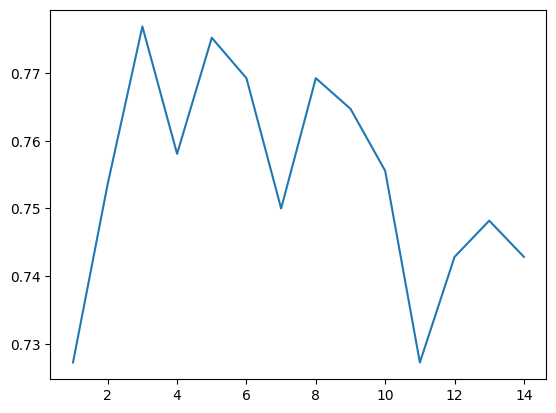

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

max_depth_dtc = np.arange(1, 15)
f1 = np.zeros(14)
for i in range(14):
  dtc = DecisionTreeClassifier(max_depth = max_depth_dtc[i], random_state=42)
  dtc.fit(X_train, y_train)
  f1[i] = f1_score(dtc.predict(X_val), y_val)

plt.plot(max_depth_dtc, f1)
plt.show()

Максимум метрики F1 на валидационной выборке достигается при max_depth = 3. Окончательно обучим модель с этим значением параметра.

In [15]:
from sklearn.metrics import confusion_matrix
dtc = DecisionTreeClassifier(max_depth=3, random_state=42)
dtc.fit(X_train, y_train)
print('F1 score:', round(f1_score(dtc.predict(X_test), y_test), 3))
print('Confusion matrix:\n',  confusion_matrix(dtc.predict(X_test), y_test))

F1 score: 0.655
Confusion matrix:
 [[101  31]
 [  9  38]]


В дальнейшем, валидационная выборка нам не понадобится, поэтому объеденим обучающую и валидационную выборку для обучения остальных моделей.

In [16]:
X_train, y_train = data_train.drop(columns=['Survived']), data_train.Survived

Обучим модель бэггинга над решающим деревом.

In [23]:
from sklearn.ensemble import BaggingClassifier

N = y_train.shape[0]
dtc_bagging = BaggingClassifier(n_estimators=N, max_samples=N, random_state=42)
dtc_bagging.fit(X_train, y_train)
print('F1 score:', round(f1_score(dtc_bagging.predict(X_test), y_test), 3))
print('Confusion matrix:\n',  confusion_matrix(dtc_bagging.predict(X_test), y_test))

F1 score: 0.758
Confusion matrix:
 [[97 19]
 [13 50]]


Модель бэггинга показала результат лучше, чем модель одного решающего дерева.

Обучим модель случайного леса.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=80,  random_state=42)
rfc.fit(X_train, y_train)
print('F1 score:', round(f1_score(rfc.predict(X_test), y_test), 3))
print('Confusion matrix:\n',  confusion_matrix(rfc.predict(X_test), y_test))

F1 score: 0.733
Confusion matrix:
 [[96 21]
 [14 48]]


Обучим модель градиентного бустинга из библиотеки scikit-learn.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc.fit(X_train, y_train)
print('F1 score:', round(f1_score(gbc.predict(X_test), y_test), 3))
print('Confusion matrix:\n',  confusion_matrix(gbc.predict(X_test), y_test))

F1 score: 0.714
Confusion matrix:
 [[98 24]
 [12 45]]


И модель градиентного бустинга из библиотеки XGBoost.

In [20]:
import xgboost as xgb

xgbc = xgb.XGBClassifier(max_depth=3, n_estimators=100)
xgbc.fit(X_train, y_train)
print('F1 score:', round(f1_score(xgbc.predict(X_test), y_test), 3))
print('Confusion matrix:\n',  confusion_matrix(xgbc.predict(X_test), y_test))

F1 score: 0.723
Confusion matrix:
 [[96 22]
 [14 47]]


Как видно, она показала результат немного лучше, чем из scikit-learn.

Итак, было обучено несколько ансамблей моделей. Лучший результат показал бэггинг над решающими деревьями (F1 = 0.758). Другие модели - случайный лес и градиентный бустинг (взятый из библиотеки XGBoost) показали результаты немного хуже. Модель одного решающего дерева показала худшие результат на метрике F1. Однако, она имеет наибольшее значение метрики recall среди всех остальных моделей, что может быть полезно, если, например, нам важно определить каждого спасшегося пассажира.

In [32]:
from sklearn.metrics import recall_score

print('Decision tree recall:', round(recall_score(dtc.predict(X_test), y_test), 3))
print('Decision tree bagging recall:', round(recall_score(dtc_bagging.predict(X_test), y_test), 3))
print('Random forest recall:', round(recall_score(rfc.predict(X_test), y_test), 3))
print('Gradient boosting recall:', round(recall_score(xgbc.predict(X_test), y_test), 3))

Decision tree recall: 0.809
Decision tree bagging recall: 0.794
Random forest recall: 0.774
Gradient boosting recall: 0.77
